# Лабораторна робота № 7
## Виконала Денисенко Анастасія, ФІ-21

# Part 1

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
folder = "data/"

images = []
labels = []

# Loop through class folders
for class_id in sorted(os.listdir(folder)):
    class_path = os.path.join(folder, class_id)
    fnames = os.listdir(class_path)

    for f in fnames:
        img = cv2.imread(os.path.join(class_path, f), cv2.IMREAD_GRAYSCALE)
        images.append(img)
        labels.append(int(class_id.split("_")[-1]))

In [4]:
# Convert to numpy
images = np.array(images)
labels = np.array(labels)

print("Images:", images.shape)
print("Labels:", labels.shape)

Images: (4470, 28, 28)
Labels: (4470,)


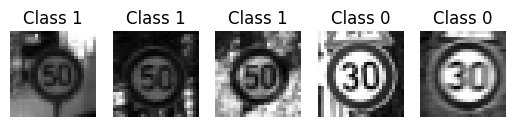

In [8]:
# Show sample images
for i in range(5):
    idx = np.random.randint(0, len(images))
    plt.subplot(1, 5, i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.axis("off")
    plt.title(f"Class {labels[idx]}")
plt.show()

In [9]:
# Count images per class
unique, counts = np.unique(labels, return_counts=True)
print("Images per class:", dict(zip(unique, counts)))

Images per class: {0: 2220, 1: 2250}


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
X = images.reshape(len(images), -1) / 255.0
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

In [12]:
print("Flattened:", X.shape)

Flattened: torch.Size([4470, 784])


In [13]:
class OneNeuron(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.linear = nn.Linear(n_inputs, 1)

    def forward(self, x):
        return self.linear(x)

model = OneNeuron(X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [14]:
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7011
Epoch 5, Loss: 0.6764
Epoch 10, Loss: 0.6633
Epoch 15, Loss: 0.6513


In [15]:
with torch.no_grad():
    preds = (torch.sigmoid(model(X)) > 0.5).float()
    accuracy = (preds == y).float().mean().item()

print("Accuracy with one neuron:", accuracy)

Accuracy with one neuron: 0.6514541506767273


In [20]:
class BetterNet(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = BetterNet(X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
epochs = 30
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7456
Epoch 5, Loss: 0.5526
Epoch 10, Loss: 0.4503
Epoch 15, Loss: 0.3565
Epoch 20, Loss: 0.2910
Epoch 25, Loss: 0.2336


In [22]:
with torch.no_grad():
    logits = model(X)
    preds = (torch.sigmoid(logits) > 0.5).float()
    accuracy = (preds == y).float().mean().item()

print(f"\nAccuracy (BetterNet): {accuracy:.4f}")


Accuracy (BetterNet): 0.9544


# Part 2

In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

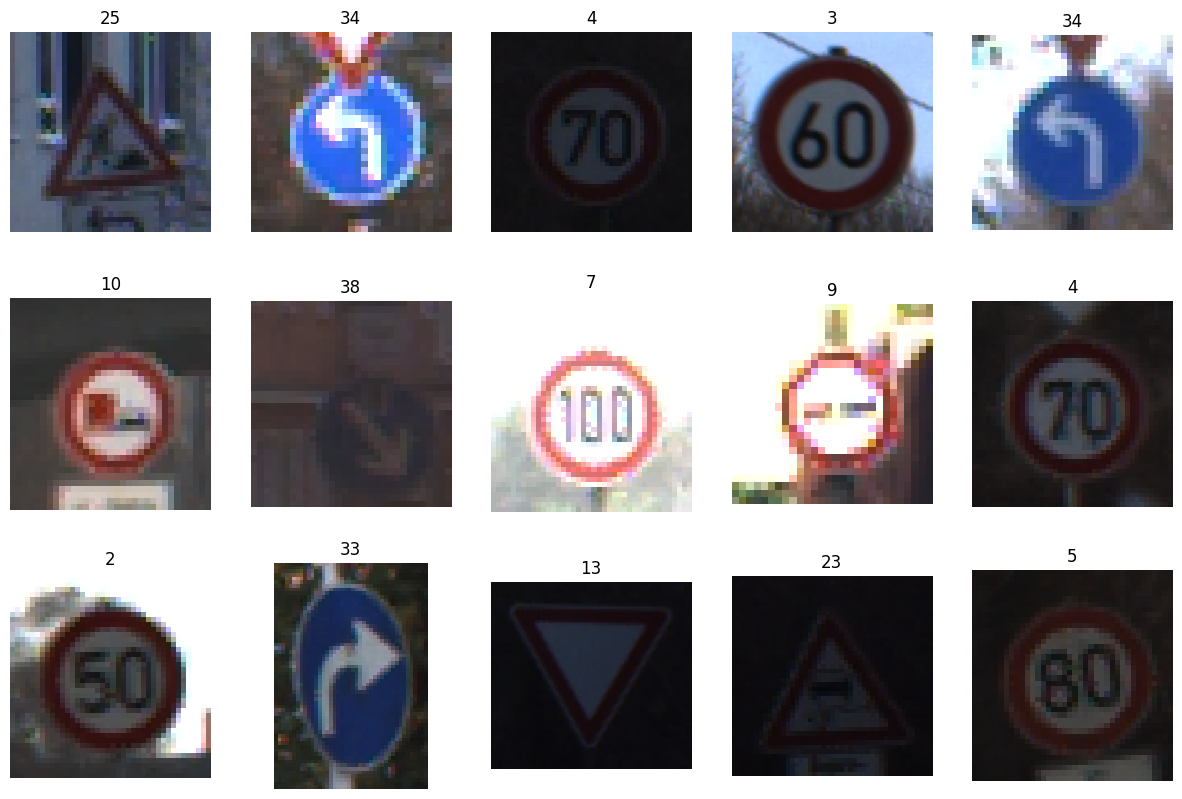

In [30]:
# Load the training labels
root = 'GTSRB/'
data = pd.read_csv(os.path.join(root, 'Train.csv'))

# Number of training samples (amount of samples in data)
num_samples = len(data)

# Show random data samples
for ii in range(15):
    # Get random index
    idx = np.random.randint(0, num_samples)
    
    # Load image
    img = cv2.imread(os.path.join(root, data.iloc[idx]['Path']))
    
    # Convert image BGR → RGB (OpenCV loads in BGR format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show image
    plt.subplot(3,5,ii+1)
    plt.imshow(img)
    plt.title(data.iloc[idx]['ClassId'])
    plt.axis("off")

In [31]:
# Extract class identifiers
ids = data['ClassId'].values

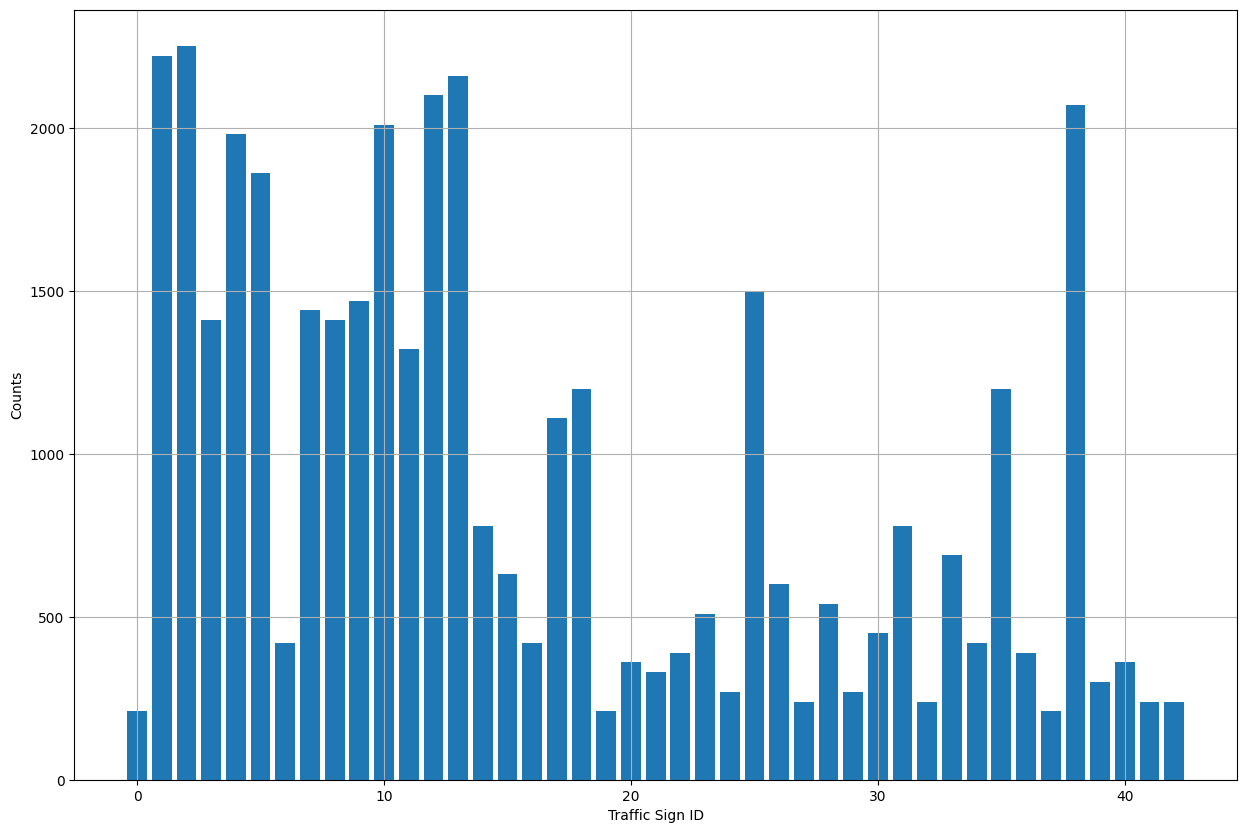

In [32]:
from collections import Counter

hist = Counter(ids)

plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Traffic Sign ID')
plt.ylabel('Counts')
plt.show()

## 1. Do you consider the dataset to be balanced? Why / why not?
No, the dataset is not balanced.
The number of samples per class varies widely — some classes have over 2000 samples, while others have fewer than 300–400. A balanced dataset would have roughly equal counts for all classes.
## 2. Are there any classes that are significantly over-represented or under-represented?
Yes.
Over-represented classes: Several classes (e.g., around IDs 0–15 and 38) have approximately 2000–2200 samples.
Under-represented classes: Many classes in the range 20–42 have only 200–600 samples.